# Feature extraction

## Background

### Feature types

In the context of the FIGO guidelines, the routinely judged FHR components, often called **FIGO-based or morphological features**, are the baseline heart rate, variability, accelerations, and decelerations. These components are the most robust indicators to ascertain fetal well-being. For this reason, in almost all studies that address automated CTG analysis, these basic morphological features are confirmed as an indispensable part of the analyses. The initial studies on automated CTG analysis focused on the detection of morphological features that clinicians examine with the naked eye, but this is challenging due to a lack of standards on how computers estimate the diagnostic indices.[[source]](https://doi.org/10.1016/j.bspc.2018.05.016)

Studies have since explored the use of other features from **linear, non-linear, discrete wavelet transform (DWT), empirical mode decomposition (EMD), time-frequency and image-based time-frequency (IBTF) domains**.[[source]](https://doi.org/10.1016/j.bspc.2018.05.016)

### Methods and software for automated CTG analysis/feature extraction during labour

Refer to `03_literature_review` for some of the publications describing this. See below for some examples of commercial software for this, that have been evaluated in clinical practice.

### Studies evaluating the use of CTG analysis systems in clinical practice

Several of the automated analysis methods have been developed as commercial products and evaluated in clinical practice. These are decision-support systems which provide alerts when there are concerns.[[source]](https://doi.org/10.3390/bioengineering10091007)

There are some systems for monitoring during labour (antenatal) (e.g. System 8000 (Dawes and Redman) and improved version called sonicadFetalCare; 2CTG2). For monitoring during labour, systems include:
* **Porto** (based on FIGO), later commercialised **SisPorto** and **Omniview-SisPorto**, and the latest version is **Sis-Porto 4.0** (based on 2015 FIGO guidelines) - as described in [Ayres-de-Campos et al. 2017](https://doi.org/10.3109/14767058.2016.1161750)
* **INFANT** (K2 Medical Systems, Plymouth, UK) - as described in [this Lancet publication](https://doi.org/10.1016%2FS0140-6736(17)30568-8), although note that the co-inventor of INFANT, co-founder of K2 Medical Systems, and member of authorship and Clinical Investigator's group resigned as author from the paper [as in this commentary](https://doi.org/10.1016/S0140-6736(17)30714-6)
* **OxSys** is a new prototype that analyses and triggers 

Most of these systems have undergone years of work, testing and clinicial validation in randomised controlled trials (RCTs). Description of some of the studies, as from [[source]](https://doi.org/10.3390/bioengineering10091007):
| Software | Study design | Sample size | Outcome |
| --- | --- | --- | --- |
| INFANT | RCT | 46042 | **No difference**. Incidence of poor neonatal outcomes was the same regardless of using the decision support system, 0.7% in both groups (adjusted risk ratio 1.01, 95% CI:0.82–1.25) |
| Omniview-SisPorto 3.5 | RCT | 7730 | **No difference**. While both study arms reported lower than expected rate of newborn metabolic acidosis, no significant reduction in the metabolic rate or obstetric intervention was achieved using computerised analysis (relative risk 0.69, 95% CI:0.36–1.31) |
| OxSys 1.5 | Retrospective | 22790 | **Sensitivity change not stat sig, FPR change was**. OxSys system potentially increased the sensitivity of fetal compromise detection (43.3% vs. 38.0% for severe, p = 0.3 and 36.1% vs. 31.0% for moderate, p = 0.06) while reducing the false positive rate (14.4% vs. 16.3%, p < 0.001) compared to conventional clinical diagnosis; however, the sensitivity increase was not statistically significant.|

Two recent **meta-analyses** also concluded similar findings that **computerised CTG analysis did not improve neonatal outcomes compared to conventional evaluation**.[[source]](https://doi.org/10.3390/bioengineering10091007)

## FHR Baseline

The FHR baseline is defined as the **mean of the signal after accelerations and decelerations have been excluded**. It is challenging to define a method for determining the FHR baseline because:
* It has a circular definition, as accelerations and decelerations are defined as periods when the signal is consistently above or below the baseline.
* There is high variability in some recordings, making it hard to distinguish between change in the baseline, and an acceleration or deceleration.[[source]](https://doi.org/10.3389/fped.2023.1190441)

M'Barek et al. 2023 state that you can overcome this issue by calibrating your method on baselines, accelerations and decelerations annotated by a consensus of obstetricians (they use those on the FHRMA dataset).[[source]](https://doi.org/10.3389/fped.2023.1190441)

Different methods have been explored for calculation of FHR baseline, with main detailed in `03_literature_review.md`. Below, I have attempted to implement one of the more simple methods.

### Taylor et al. (2000)

[Taylor et al. 2000](https://doi.org/10.1111/j.1471-0528.2000.tb11112.x) - The development and validation of an algorithm for real-time computerised fetal heart rate monitoring in labour

As described in their paper, this involves:

1. **Interpolation of invalid data points:** Remove periods of signal loss by detecting large deviations in fetal heart rate, and values outside of accepted range of 55-200bpm. These readings are discarded and replaced by linear interpolation between valid data points.

2. **Use Butterworth filter to generate coarse starting baseline:** Low pass filter using third order zero-phase (two-pass) Butterworth filter with frequency cut off of 0.008Hz

3. **Remove deviations, perform interpolation, and apply butterworth filter** Remove deviations of +- 5bpm from the initial baseline. Then linear interpolation. Then low pass Butterworth filter with cut-off frequency of 0.006 Hz. This was a lower cut off frequency than that used for obtaining the starting baseline, because many of the deviations from the baseline had already been removed in the first filtering process that generated the starting baseline.

4. **Repeat that twice more**. This creates a three-stage process the generates progressively improved intermediary baselines.

5. **Determine baseline**. The mean value of baseline for a give period (e.g. they show 25-minute segment) gives the baseline fetal heart rate for that segment.

### Implementation in MATLAB

Boudet et al. implement Taylor et al. in the FHRMA toolbox, as in [this MATLAB function](https://github.com/utsb-fmm/FHRMA/blob/master/aamtaylor.m) which is copied below. It uses [FHRMA::butterfilt()](https://github.com/utsb-fmm/FHRMA/blob/master/butterfilt.m), which is a complete butterworth filter process. It also uses [FHRMA::interpolFHR](https://github.com/utsb-fmm/FHRMA/blob/master/interpolFHR.m), which replaces 0s in FHR corresponding to signal missing by linear interpolation.

I can't spot the mentioned pre-processing stages about periods of signal loss. It's unclear from Taylor et al. 2000 whether this only referred to extreme values, or whether there were certain lengths of time that were dropped (which is common in CTG pre-processing).

```
FHRi=FHR;
FHRbl=FHRi;

bl1=butterfilt(FHRi,4,0,0.008,3,1);
FHRbl(FHRi-bl1>5)=0;
FHRbl(FHRi-bl1<-5)=0;

bl2=butterfilt(interpolFHR(FHRbl),4,0,0.006,3,1);
FHRbl(FHRi-bl2>5)=0;
FHRbl(FHRi-bl2<-5)=0;

bl3=butterfilt(interpolFHR(FHRbl),4,0,0.006,3,1);
FHRbl(FHRi-bl3>10)=0;
FHRbl(FHRi-bl3<-5)=0;

baseline=butterfilt(interpolFHR(FHRbl),4,0,0.006,3,1);
``````

To explain their butterworth filter, with first example:
* Signal = FHRi
* Sampling rate = 4
* F1 = 0, meaning low pass at F2
* F2 = 0.008
* Order of filter = 3
* Forward-Backward filter = 1 means True

### Explanation of butterworth filters

Copied from: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

Consider the example data below. When you zoom in, you can see the noise in the data. If you wanted to find the point where the curve starts its rise, it would be difficult due to the noise making it likely you get a false positive result, and the performance of the algorithm would be impacted by the fluctuation in the data too.

![Signal](./images/noisy_signal.png)
![Zoomed in](./images/noisy_signal_zoom.png)

In signal processing, there are four common filters:
* **Low-pass filters** = pass signals below cut-off and attenuate signals above it
* **High-pass filters** = pass signals above cut-off and attenuate signals below it
* **Band-pass filters** = combination of low-pass and high-pass filter, passes frequencies that fall between the two cut-offs
* **Band-reject/band-stop/notch filters** = passes frequencies that fall outside of the range of the low-pass and high-pass cutoffs

The range of frequencies that a filter can pass through is called its **passband**. The range of frequencies attentuated or not passed by a filter is its **stopband**. A filter can have more than one - e.g. a bandpass filter has a passband with a high stopband above and low stopband below.

A **frequency response** refers to how a filter/signal processing system changes the amplitude and phase of various frequencies in the signal. Its usually represented graphically with a **response curve** showing the magnitude/amplitude and phase shift of the output signal compared to the input signal, across a range of frequencies.

![Filter types](./images/filter_types.png)

One type of signal processing filter is the **butterworth filter** (also known as the maximally flat magnitude filter).

The butterworth filter has a **flat frequency response in the passband**, i.e. is maximally flat. This means that all frequencies in the passband are passed with the same amplification or attenuation, ensuring a uniform treatment of those frequencies. This doesn't mean that amplitude is removed, but instead means frequencies are treated equally, and there's no preferential treatment or emphasis on certain frequencies over others.

The butterworth filter also **rolls off to zero in the stopband** (gradual roll-off rate). Roll-off is the rate at which the filter transitions between the passband and stopband.

![Butterworth filter frequency response](./images/butterworth_frequency_response.png)


The order of the filters determines how rapidly the filters response changes from the passband to the stopband. High-order butterworth filters have steeper roll-off. Higher-order Butterworth filters provide a more rapid attenuation of frequencies outside the passband, but they might also introduce phase distortions or higher complexity in their implementation. Image below from [here](https://dsp.stackexchange.com/questions/60455/how-to-choose-order-and-cut-off-frequency-for-low-pass-butterworth-filter).

![Butterworth filter orders](./images/butterworth_orders.png)

Filters have a delay/lag and don't act immediately on the signal. All samples before time 0 are 0, so when you pass the filter, you'll often see that it has made your signal start from 0.

To make the filter have zero lag, we do **zero-phase filtering**, also known as forward-backward filtering or two-pass. It works by filtering the signal twice in the forward and backward direction.

### Implementation in Python

#### Set up

In [1]:
# Import packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [4]:
# Choose a record and set fhr object to have it's fetal heart rate signal
chosen_record = csv_files['1001']
fhr = chosen_record['FHR'].copy()
fhr

0        150.50
1        150.50
2        151.00
3        151.25
4        151.25
          ...  
19195      0.00
19196      0.00
19197      0.00
19198      0.00
19199      0.00
Name: FHR, Length: 19200, dtype: float64

#### Step 1: Interpolate invalid data points

Remove periods of signal loss by detecting large deviations in fetal heart rate, and values outside of accepted range of 55-200bpm. These readings are discarded and replaced by linear interpolation between valid data points.

In [5]:
# Set outliers to NaN
fhr[fhr < 55] = np.nan
fhr[fhr > 200] = np.nan

# Replace missing values using linear interpolation
fhr = fhr.interpolate(method='linear')
fhr

0        150.50
1        150.50
2        151.00
3        151.25
4        151.25
          ...  
19195     91.50
19196     91.50
19197     91.50
19198     91.50
19199     91.50
Name: FHR, Length: 19200, dtype: float64

#### Step 2: Generate coarse baseline

Low pass filter using third order zero-phase (two-pass) Butterworth filter with frequency cut off of 0.008Hz

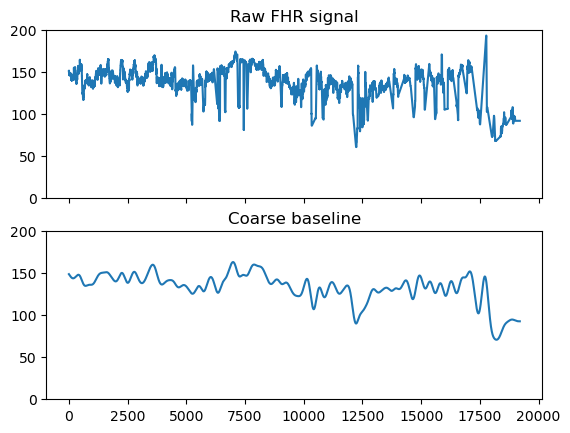

In [6]:
# Generate butterworth filter
b, a = butter(
    N=3, # Filter's order
    Wn=0.008, # Critical frequency
    btype='low', # Kind of filter
    fs = 4, # Sampling frequency
    output='ba' # Output type
)

# Use filtfilt() (instead of sosfilt) as it applies the filter
# twice, forwards and backwards, so you get zero-phase filtering
coarse = filtfilt(b, a, fhr)

# Plot before and after
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(fhr)
ax1.set_ylim([0, 200])
ax1.set_title('Raw FHR signal')
ax2.plot(coarse)
ax2.set_ylim([0, 200])
ax2.set_title('Coarse baseline')
plt.show()

#### Step 3: Apply three rounds of removing deivations, interpolation, and butterworth filters

Remove deviations of +- 5bpm from the initial baseline. Then linear interpolation. Then low pass Butterworth filter with cut-off frequency of 0.006 Hz. This was a lower cut off frequency than that used for obtaining the starting baseline, because many of the deviations from the baseline had already been removed in the first filtering process that generated the starting baseline.

Repeat that twice more. This creates a three-stage process the generates progressively improved intermediary baselines.

<Axes: >

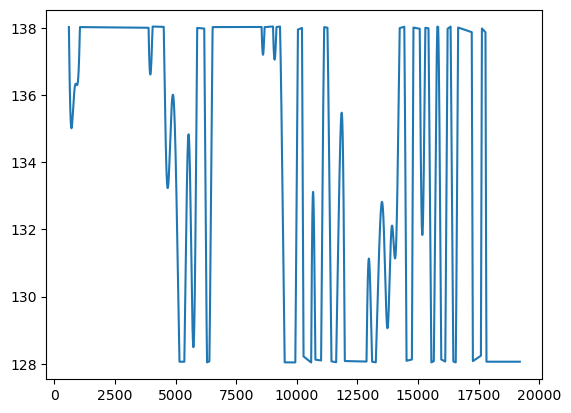

In [7]:
# Find initial baseline
baseline = coarse.mean()

# Set to NaN if +- 5pm from that baseline
coarse[coarse < baseline-5] = np.nan
coarse[coarse > baseline+5] = np.nan

# Replace missing values using linear interpolation
new_sig = pd.Series(coarse).interpolate(method='linear')
new_sig.plot()

<Axes: >

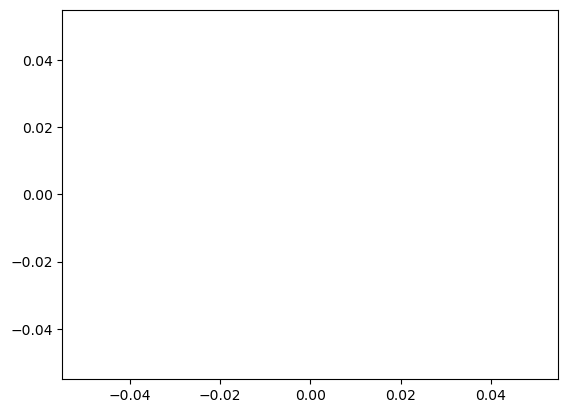

In [8]:
# Create butterworth filter
b, a = butter(
    N=3, # Filter's order
    Wn=0.006, # Critical frequency
    btype='low', # Kind of filter
    fs = 4, # Sampling frequency
    output='ba' # Output type
)

# Apply butterworth filter
new = filtfilt(b, a, new_sig)
pd.Series(new).plot()